<a href="https://colab.research.google.com/github/Sg-27/Optical-Character-Recognition/blob/main/Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, random_split
import torchvision.transforms as transforms




In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(f"We are training on {device} for this experiment")

assert 'cuda' in repr(device), "GPU is not selected in hardware accelerator dropdown"

We are training on cuda:0 for this experiment


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
your_google_drive_path = "/content/drive/MyDrive/Custom Dataset/"
import os
assert os.path.isdir(your_google_drive_path), f"{your_google_drive_path} is not a valid location"

In [ ]:
class CustomDigitsDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.data, self.labels = self.load_data()


    def load_data(self):
        data = []
        labels = []
        digit_folders = sorted(os.listdir(self.root_folder))

        for label, digit_folder in enumerate(digit_folders):
            digit_path = os.path.join(self.root_folder, digit_folder)
            for image_name in os.listdir(digit_path):
                image_path = os.path.join(digit_path, image_name)
                img = Image.open(image_path).convert('L')  # Convert to grayscale

                data.append(img)
                labels.append(label)
                #print(label)

        return data, labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize(size=(32,32))
# ])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(32,32)),
    transforms.CenterCrop(size=(24,24))
])
batch_size=4

# Specify the path to the root folder containing digit folders
#root_folder_path = '/path/to/root_folder'
your_google_drive_path='/content/drive/MyDrive/Custom Dataset'
custom_dataset = CustomDigitsDataset(your_google_drive_path, transform=transform)

# Split the dataset into training and testing sets
print(len(custom_dataset))
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# Example usage:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


540


In [ ]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

torch.Size([4, 1, 24, 24])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


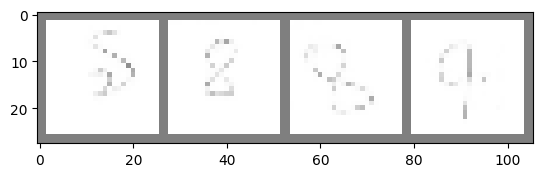

nine  four  four  seven


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an imageonefinal22@gmail.com


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
classes = ('zero', 'one', 'two', 'three',
           'four', 'five','six','seven','eight','nine')
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch
import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms

# Define the basic block for the ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define the ResNet-9 model
class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.block1 = BasicBlock(64, 128, stride=2)
        self.block2 = BasicBlock(128, 256, stride=2)
        self.block3 = BasicBlock(256, 512, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet9().to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def validator(test_loader=None,model=None):
    correct = 0
    total = 0
    model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            # perform max along dimension 1, since dimension 0 is batch dimension
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 540 test images: {100 * correct // total} %')
    return correct/total

In [ ]:
start_epoch=0
end_epoch=20

In [ ]:
your_google_drive_path="/content/drive/MyDrive/check_point/"

In [ ]:
best_accuracy = -1.0
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    current_accuracy = validator(test_loader=test_loader,model=model)
    if current_accuracy>best_accuracy:
        best_accuracy = current_accuracy

        torch.save(
            {'epoch':epoch,
             'model_state_dict': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict()
             },

             your_google_drive_path+'best_model.pth')

    #Save model as checkpoint
    torch.save(
        {'epoch':epoch,
         'model_state_dict': model.state_dict(),
         'optimizer_state_dict': optimizer.state_dict()
         },
         your_google_drive_path+'checkpoint.pth')



print('Finished Training')

Accuracy of the network on the 540 test images: 45 %
Accuracy of the network on the 540 test images: 50 %
Accuracy of the network on the 540 test images: 60 %
Accuracy of the network on the 540 test images: 68 %
Accuracy of the network on the 540 test images: 67 %
Accuracy of the network on the 540 test images: 62 %
Accuracy of the network on the 540 test images: 69 %
Accuracy of the network on the 540 test images: 76 %
Accuracy of the network on the 540 test images: 75 %
Accuracy of the network on the 540 test images: 72 %
Accuracy of the network on the 540 test images: 72 %
Accuracy of the network on the 540 test images: 73 %
Accuracy of the network on the 540 test images: 73 %
Accuracy of the network on the 540 test images: 73 %
Accuracy of the network on the 540 test images: 73 %
Accuracy of the network on the 540 test images: 74 %
Accuracy of the network on the 540 test images: 74 %
Accuracy of the network on the 540 test images: 74 %
Accuracy of the network on the 540 test images

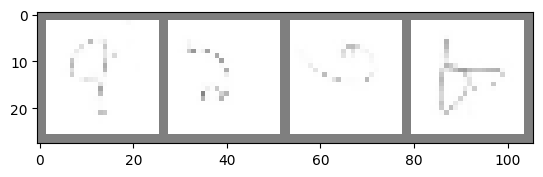

seven one   three eight


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels=next(dataiter)
batch_size=4

# print images
imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
net_best = ResNet9().to(device)
checkpoint = torch.load(your_google_drive_path+'best_model.pth')
net_best.load_state_dict(checkpoint['model_state_dict'])


images = images.to(device)
labels = labels.to(device)

outputs = net_best(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  seven four  three eight
